In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras 

from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D, UpSampling2D, Dropout, Flatten
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar100
from keras import backend as K
import tensorflow

In [2]:
def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

In [3]:
(x_train, _), (x_test, _) = cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [4]:
x_train_gray = rgb_2_gray(x_train)
x_test_gray = rgb_2_gray(x_test)

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
 
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

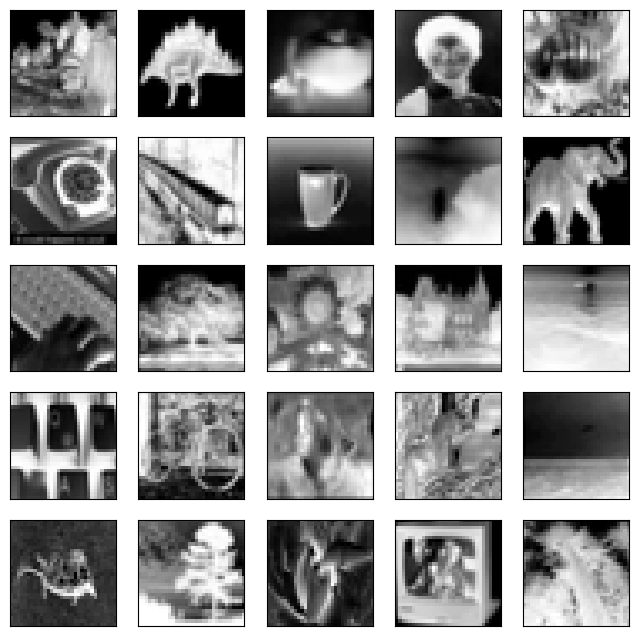

In [6]:
plt.figure(figsize = (8,8))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(x_train_gray[i], cmap = plt.cm.binary )
  plt.xticks([])
  plt.yticks([])

plt.show()

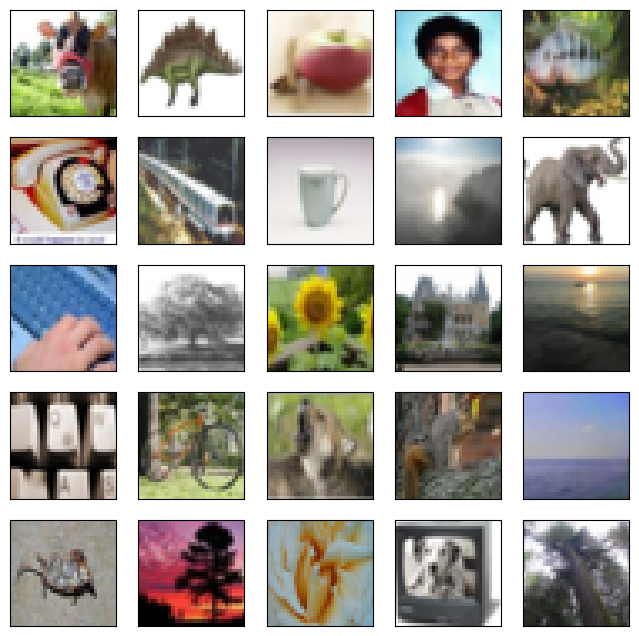

In [7]:
plt.figure(figsize = (8,8))
for i in range(25):
  plt.subplot(5,5,i+1)
#   plt.title(str(x_train[i]),fontsize = 16, color = 'black', pad = 2)
  plt.imshow(x_train[i], cmap = plt.cm.binary )
  plt.xticks([])
  plt.yticks([])

plt.show()

# CAE

In [8]:
input_shape = (32,32,1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

In [9]:
inputs = Input(shape = input_shape)
x = inputs
for filters in layer_filters:
  x = Conv2D(filters = filters,
           kernel_size = kernel_size,
           strides = 2,
           activation ='relu',
           padding ='same')(x)
 
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name ='latent_vector')(x)
encoder = Model(inputs, latent, name ='encoder')

In [10]:
channels = 3
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-
# Conv2DTranspose(64)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      strides = 2,
                      activation ='relu',
                      padding ='same')(x)
outputs = Conv2DTranspose(filters = channels,
                          kernel_size = kernel_size,
                          activation ='sigmoid',
                          padding ='same',
                          name ='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name ='decoder')

In [11]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name ='autoencoder')

In [12]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [13]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

In [14]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.001)
LOSS = 'mean_squared_error'
autoencoder.compile(optimizer, loss = LOSS, metrics = ['accuracy'])

In [16]:
EPOCHS = 100
my_callbacks_cae = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history = autoencoder.fit(x_train_gray, x_train, epochs = EPOCHS, validation_data = (x_test_gray, x_test), callbacks = my_callbacks_cae)

Epoch 1/100
1563/1563 [==============================] - 33s 12ms/step - loss: 0.0185 - accuracy: 0.5032 - val_loss: 0.0142 - val_accuracy: 0.4922
Epoch 2/100
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0134 - accuracy: 0.5145 - val_loss: 0.0131 - val_accuracy: 0.4731
Epoch 3/100
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0124 - accuracy: 0.5207 - val_loss: 0.0127 - val_accuracy: 0.5292
Epoch 4/100
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0118 - accuracy: 0.5255 - val_loss: 0.0118 - val_accuracy: 0.5023
Epoch 5/100
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0113 - accuracy: 0.5260 - val_loss: 0.0116 - val_accuracy: 0.4874
Epoch 6/100
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0110 - accuracy: 0.5306 - val_loss: 0.0114 - val_accuracy: 0.5424
Epoch 7/100
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0106 - accuracy: 0.5323 - val_loss: 0

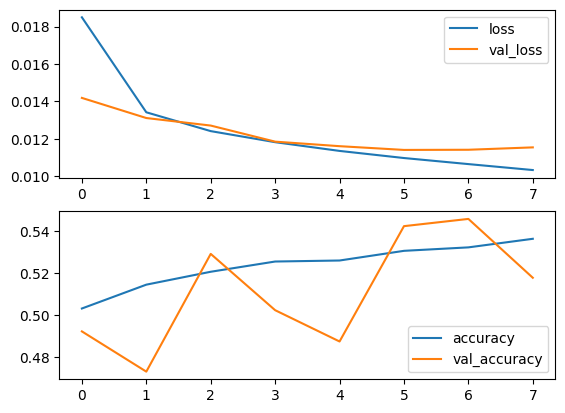

In [17]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'best')
plt.show()

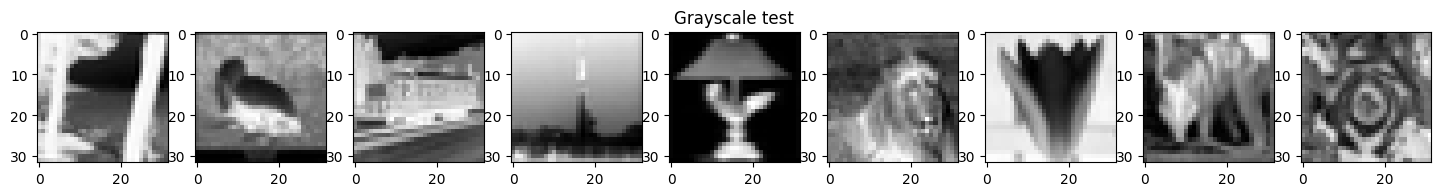

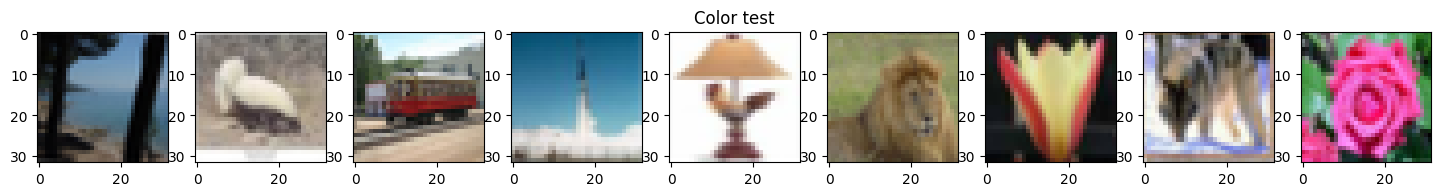

1/1 [==============================] - 0s 21ms/step


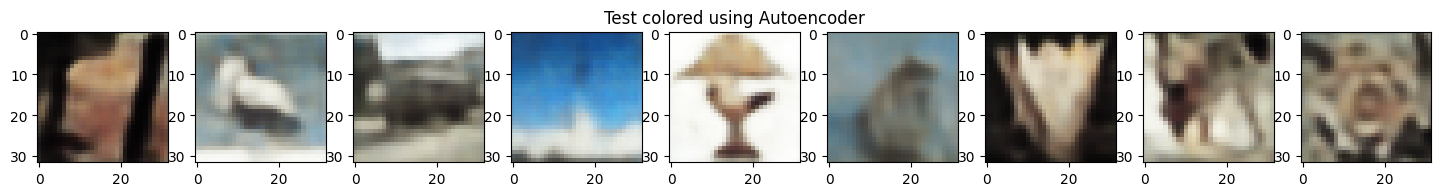

In [22]:
plt.figure(figsize = (18,18))
for i in range(10,19):
    plt.subplot(9,9,i)
    if(i == 14):
        plt.title('Grayscale test') 
    plt.imshow(x_test_gray[i].reshape(1,32,32)[0], cmap = plt.cm.binary)
plt.show()


plt.figure(figsize = (18,18))
for i in range(10,19):
    if(i == 15):
        plt.title('Color test') 
    plt.subplot(9,9,i)
    plt.imshow(x_test[i].reshape(1,32,32,3)[0], cmap = plt.cm.binary)
plt.show()


plt.figure(figsize = (18,18))
for i in range(10,19):  
    if(i == 15):
        plt.title('Test colored using Autoencoder') 
    
    plt.subplot(9,9,i)
    plt.imshow(autoencoder.predict(x_test_gray[i].reshape(1,32,32)).reshape(1,32,32,3)[0], cmap = plt.cm.binary) 
plt.show()